Final Project:
Using 'news summary' dataset
This encoder-decoder model worked on this dataset and the results are good.

In [ ]:
# import libraries
import json
import pandas as pd
import numpy as np
pd.set_option('display.max_colwidth', -1)

<ipython-input-56-2a92a600da02>:5: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# load the cleaned data

data = pd.read_csv('/data/cleaned_data_news_summary_more.csv')

Add start and end tokens for summary(headlines)

In [ ]:
data.columns
print(data.dtypes)

Unnamed: 0.1     int64 
Unnamed: 0       int64 
summary          object
text             object
clean_summary    object
clean_text       object
dtype: object


In [ ]:
data.clean_summary = data.clean_summary.apply(lambda x: f'_START_ {x} _END_')

Again add different tokens
'sostok' and 'eostok' as start and end tokens respectively as later while using tensorflow's Tokenizer will filter the tokens and covert them to lowercase

In [ ]:
start_token = 'sostok'
end_token = 'eostok'
data.clean_summary = data.clean_summary.apply(lambda x: f'{start_token} {x} {end_token}')

In [ ]:
data.sample(5)

,Unnamed: 0.1,Unnamed: 0,summary,text,clean_summary,clean_text
99810,99810,99810,"SC orders protection for Kathua rape victims family, lawyer","The Suprtheme Court on Monday directed the J&K government to provide police protection to the family of the eight-year-old Kathua rape and murder victim and their counsel Deepika S Rajawat. The counsel on Sunday alleged her life is in danger, adding she was being threatened after taking over the case. The trial against the eight accused began in Kathua today.",sostok _START_ sc orders protection kathua rape victims family lawyer _END_ eostok,suprtheme court monday directed jk government provide police protection family eightyearold kathua rape murder victim counsel deepika rajawat counsel sunday alleged life danger adding threatened taking case trial eight accused began kathua today
37725,37725,37725,"Seaweed drifts 20,000 km to reach isolated Antarctica: Study","Researchers led by Australian National University have found the first proof that Antarctica is not isolated from the rest of the Earth, with the discovery of foreign seaweed that drifted 20,000 kilometres to reach there. Researchers suggested such biological rafts could be used by plants and animals to populate the icy continent as soon as the local environment becomes hospitable.",sostok _START_ seaweed drifts 20000 km reach isolated antarctica study _END_ eostok,researchers led australian national university found first proof antarctica isolated rest earth discovery foreign seaweed drifted 20000 kilometres reach there researchers suggested biological rafts could used plants animals populate icy continent soon local environment becomes hospitable
1654,1654,1654,Ã¢ÂÂ¹100 crore needed to make ATMs ready for new Ã¢ÂÂ¹100 notes: Operators,"The ATM operations industry on Friday said an investment of Ã¢ÂÂ¹100 crore will be needed to recalibrate 2.4 lakh ATMs across the country to make ththem ready for dispensing new Ã¢ÂÂ¹100 notes. ""Over 12 months of time will be needed for recalibration,"" said Hitachi Payment Services Managing Director. RBI on Thursday announced it will issue new lavender-coloured Ã¢ÂÂ¹100 notes shortly.",sostok _START_ ã¢ââ¹100 crore needed make atms ready new ã¢ââ¹100 notes operators _END_ eostok,atm operations industry friday said investment ã¢ââ¹100 crore needed recalibrate 24 lakh atms across country make ththem ready dispensing new ã¢ââ¹100 notes over 12 months time needed recalibration said hitachi payment services managing director rbi thursday announced issue new lavendercoloured ã¢ââ¹100 notes shortly
41685,41685,41685,"Ã¢ÂÂ¹65,400 s mattress to monitor sleeping pattern made","US-based developer Eight Team has designed a Ã¢ÂÂ¹65,400 s mattress which monitors users sleeping patterns and regulates bed tthemperature. The mattress contains sensors which are connected to an app called Eight available both on iOS and Android. Users can create their own account on the Eight app to track sleep and manage bed side features.",sostok _START_ ã¢ââ¹65400 mattress monitor sleeping pattern made _END_ eostok,usbased developer eight team designed ã¢ââ¹65400 mattress monitors users sleeping patterns regulates bed tthemperature mattress contains sensors connected app called eight available ios android users create account eight app track sleep manage bed side features
17603,17603,17603,Online quiz taken by Chris Pratt tells him he is Chris Evans,"Guardians of the Galaxy actor Chris Pratt took an online quiz ""Are You Chris, Chris, Chris, or Chris"" and based on his answers, he was ared Captain America actor Chris Evans. Sharing a screenshot of the quiz results, Pratt wrote, ""Dude I suck at quizzes."" Replying to his post, Evans jokingly tweeted, ""What do you mean? You aced it.""",sostok _START_ online quiz taken chris pratt tells chris evans _END_ eostok,guardians galaxy actor chris pratt took online quiz are chris chris chris chris based answers ared captain america actor chris evans sharing screenshot 

In [ ]:
data['clean_text'] #.astype(str)

0         gujarat court friday rejected bail application filed former ips officer sanjiv bhatt behind bars since septthember connection 22yearold drug seizure case led bhatt gujarats banaskantha police arrested man charges possessing drugs although investigation rajasthan police revealed allegedly falsely implicated ththem
1         suprtheme court monday dismissed pil seeking indus waters treaty india pakistan illegal unconstitutional litigant argued indus pact treaty signed name president india prime minister jawaharlal nehru                                                                                                                    
2         telugu desam party tdp mp jayadev galla suggested lok sabha big currency notes expiry date dthemonetisation time time galla added ã¢ââ¹200 notes introduced ã¢ââ¹2000 notes withdrawn galla also suggested order motivate taxpayers facilities provided ththem                                                          
3         reliance indust

Step 3: Determine max sequence length

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

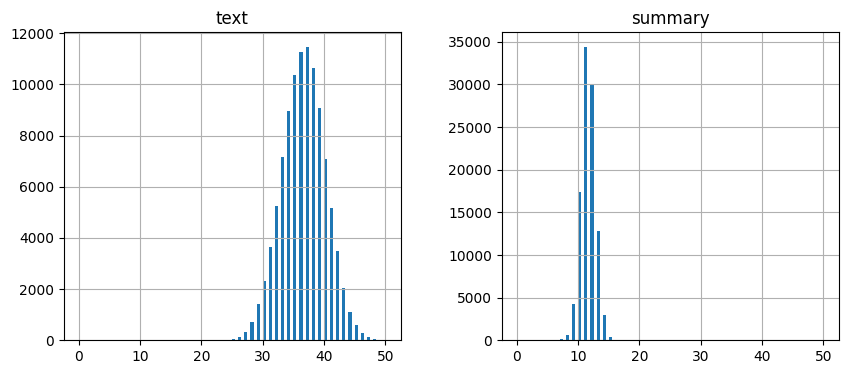

In [ ]:
text_count = [len(sentence.split()) for sentence in data.clean_text]
summary_count = [len(sentence.split()) for sentence in data.clean_summary]

pd.DataFrame({'text': text_count, 'summary': summary_count}).hist(bins=100, figsize=(10, 4), range=[0, 50])
#pd.DataFrame({'summary': summary_count}).hist(bins=100, figsize=(10, 4), range=[0, 30])
plt.show()

From the graphs, you can determine the range where the maximum number of words fall into. For title, you can assign the range to be 0-20.

In [ ]:
# To check how many % in a columns has length (of the text) <= limit
def get_word_percent(column, limit):
    count = 0
    for sentence in column:
        if len(sentence.split()) <= limit:
            count += 1

    return round(count / len(column), 2)

# Check how many % of summary(headlines) have 0-13 words
print(get_word_percent(data.clean_summary, 13))

# Check how many % of text have 0-43 words
print(get_word_percent(data.clean_text, 43))

0.97
0.98


We can observe, 97% of the content pieces fall into the 0-42 category.

Initialize the maximum permissible lengths of both title and content

In [ ]:
# Model to summarize the text between 0-15 words for Summary and 0-50 words for Text
max_summary_len = 13
max_text_len = 43

4. Select summary(headline) and text(content) which are between these max length mentioned above

In [ ]:
# select the summary and text between their defined max lens respectively
def trim_text_and_summary(data, max_text_len, max_summary_len):
    cleaned_text = np.array(data['clean_text'])
    cleaned_summary = np.array(data['clean_summary'])

    short_text = []
    short_summary = []

    for i in range(len(cleaned_text)):
        if len(cleaned_text[i].split()) <= max_text_len and len(
            cleaned_summary[i].split()
        ) <= max_summary_len:
            short_text.append(cleaned_text[i])
            short_summary.append(cleaned_summary[i])

    data = pd.DataFrame({'text': short_text, 'summary': short_summary})
    return data

In [ ]:
data = trim_text_and_summary(data, max_text_len, max_summary_len)
print(f'Dataset size: {len(data)}')
data.sample(5)

Dataset size: 97527


,text,summary
58733,selfstyled godman daati maharaj said 25yearold woman follower accused rape dter put allegations her even hanged put allegations her done anything wrong legal authorities look that added,sostok _START_ girl dter godman rape charge _END_ eostok
35236,10minute helicopter ride service cost ã¢ââ¹2900 launched sunday visitors statue unity worlds tallest statue situated gujarats kevadia statue unity inrated prime minister narendra modi october 31 gujarat government built statue cost around ã¢ââ¹3000 crore 33 months,sostok _START_ helicopter service launched statue unity ã¢ââ¹2900 _END_ eostok
7909,retiring england opener alastair cook got 33rd test hundred five overthrows said overthrow india pacer jasprit bumrah saved lot heartache cook cut ravindra jadeja delivery get 97 bumrah threw ball hard stumps resulting four overthrows i thank bumrah while cook added,sostok _START_ bumrahs overthrow saved lot heartache alastair cook _END_ eostok
79285,according delhi high court ruling event organisers pay royalty using copyrighted songs inform three copyright societies including indian performing right society phonographic performance ltd copyrighted work used one shall issue invoice royalty copyright,sostok _START_ event organisers pay royalty use copyrighted songs _END_ eostok
11827,former finance minister p chidambaram said current gst imperfect a mockery delayed two months the aim one indirect tax subsume indirect taxes gst fails achieve that said added congress press reduction rates 18 cap,sostok _START_ current gst mockery imperfect former finance minister _END_ eostok


In [ ]:
data.summary[5]

'sostok _START_ ball play 22 minutes french open final _END_ eostok'

In [ ]:
# rare word analysis
def get_rare_word_percent(tokenizer, threshold):
    # threshold: if the word's occurrence is less than this then it's rare word

    count = 0
    total_count = 0
    frequency = 0
    total_frequency = 0

    for key, value in tokenizer.word_counts.items():
        total_count += 1
        total_frequency += value
        if value < threshold:
            count += 1
            frequency += value

    return {
        'percent': round((count / total_count) * 100, 2),
        'total_coverage': round(frequency / total_frequency * 100, 2),
        'count': count,
        'total_count': total_count
    }

Seq2seq model building

In [ ]:
import tensorflow as tf
import pickle
from tensorflow.keras import Input, Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Embedding, TimeDistributed

Split the data
X = text
y=summary

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(np.array(data['text']),
                                                      np.array(data['summary']),
                                                      test_size=0.2,
                                                      random_state=0,
                                                      shuffle=True)

In [ ]:
print(X_train.shape)
print(X_valid.shape)
print(y_train.shape)
print(y_valid.shape)

(78021,)
(19506,)
(78021,)
(19506,)


prepare and tokenize text data

Tokenize text X

In [ ]:
# prepare x tokenizer
x_tokenizer = Tokenizer()
x_tokenizer.fit_on_texts(list(X_train))

x_tokens_data = get_rare_word_percent(x_tokenizer, 4)

print(x_tokens_data)

{'percent': 66.98, 'total_coverage': 3.48, 'count': 70327, 'total_count': 104992}


In [ ]:
# save tokenizer
with open('x_tokenizer', 'wb') as f:
    pickle.dump(x_tokenizer, f, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
# one-hot-encoding
x_train_sequence = x_tokenizer.texts_to_sequences(X_train)
x_val_sequence = x_tokenizer.texts_to_sequences(X_valid)

# padding upto max_text_len
x_train_padded = pad_sequences(x_train_sequence, maxlen=max_text_len, padding='post')
x_val_padded = pad_sequences(x_val_sequence, maxlen=max_text_len, padding='post')

# size of x vocabulary (+1 for padding token)
x_vocab_size = len(x_tokenizer.word_index) + 1

print(x_vocab_size)

104993


Tokenize summary(headline) y

In [ ]:
# prepare y tokenizer
y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(list(y_train))

y_tokens_data = get_rare_word_percent(y_tokenizer, 6)
print(y_tokens_data)

{'percent': 71.55, 'total_coverage': 5.85, 'count': 28495, 'total_count': 39823}


In [ ]:
# save tokenizer
with open('y_tokenizer', 'wb') as f:
    pickle.dump(y_tokenizer, f, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
# one-hot-encoding
y_train_sequence = y_tokenizer.texts_to_sequences(y_train)
y_val_sequence = y_tokenizer.texts_to_sequences(y_valid)

# padding upto max_summary_len
y_train_padded = pad_sequences(y_train_sequence, maxlen=max_summary_len, padding='post')
y_val_padded = pad_sequences(y_val_sequence, maxlen=max_summary_len, padding='post')

# size of y vocabulary (+1 for padding token)
y_vocab_size = len(y_tokenizer.word_index) + 1

print(y_vocab_size)

39824


Removing Summaries which only has sostok and eostok

In [ ]:
# removing summary which only has sostok & eostok
def remove_indexes(summary_array):
    remove_indexes = []
    for i in range(len(summary_array)):
        count = 0
        for j in summary_array[i]:
            if j != 0:
                count += 1
        if count == 2:
            remove_indexes.append(i)
    return remove_indexes


remove_train_indexes = remove_indexes(y_train_padded)
remove_val_indexes = remove_indexes(y_val_padded)

y_train_padded = np.delete(y_train_padded, remove_train_indexes, axis=0)
x_train_padded = np.delete(x_train_padded, remove_train_indexes, axis=0)

y_val_padded = np.delete(y_val_padded, remove_val_indexes, axis=0)
x_val_padded = np.delete(x_val_padded, remove_val_indexes, axis=0)

In [ ]:
print(X_train.shape)
print(X_valid.shape)

print(y_train.shape)
#print(y_train.reshape[:,:-1])
print(y_valid.shape)

(78021,)
(19506,)
(78021,)
(19506,)


7. Create the model

In [ ]:
latent_dim = 240
embedding_dim = 300
num_epochs = 50

Using pre-trained embeddings and keeping the Embedding layer non-trainable we get increase in computation speed as don't need to compute the embedding matrix

In [ ]:
import os

In [ ]:
def get_embedding_matrix(tokenizer, embedding_dim, vocab_size=None):
  word_index = tokenizer.word_index
  voc = list(word_index.keys())

  path_to_glove_file = '/content/gdrive/MyDrive/612_DeepLearning/Final_Project/glove.6B.300d.txt'

  embeddings_index = {}
  with open(path_to_glove_file) as f:
    for line in f:
      word, coefs = line.split(maxsplit=1)
      coefs = np.fromstring(coefs, "f", sep=" ")
      embeddings_index[word] = coefs

  print("Found %s word vectors." % len(embeddings_index))

  num_tokens = len(voc) + 2 if not vocab_size else vocab_size
  hits = 0
  misses = 0

# Prepare embedding matrix
  embedding_matrix = np.zeros((num_tokens, embedding_dim))
  for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
      # Words not found in embedding index will be all-zeros.
      # This includes the representation for "padding" and "OOV"
      embedding_matrix[i] = embedding_vector
      hits += 1
    else:
      misses += 1
  print("Converted %d words (%d misses)" % (hits, misses))

  return embedding_matrix

x_embedding_matrix = get_embedding_matrix(x_tokenizer, embedding_dim, x_vocab_size)
y_embedding_matrix = get_embedding_matrix(y_tokenizer, embedding_dim, y_vocab_size)

Found 400000 word vectors.
Converted 55921 words (49071 misses)
Found 400000 word vectors.
Converted 27364 words (12459 misses)


In [ ]:
print(x_embedding_matrix.shape)
print(y_embedding_matrix.shape)

(104993, 300)
(39824, 300)


Seq model with LSTMs
Both encoder and decoder have just LSTMs

In [ ]:
def build_seq2seq_model_with_just_lstm(
    embedding_dim, latent_dim, max_text_len,
    x_vocab_size, y_vocab_size,
    x_embedding_matrix, y_embedding_matrix
):
    # instantiating the model in the strategy scope creates the model on the TPU
    #with tpu_strategy.scope():

        # =====================
        # Encoder
        # =====================
        encoder_input = Input(shape=(max_text_len, ))

        # encoder embedding layer
        encoder_embedding = Embedding(
            x_vocab_size,
            embedding_dim,
            embeddings_initializer=tf.keras.initializers.Constant(x_embedding_matrix),
            trainable=False
        )(encoder_input)

        # encoder lstm 1
        encoder_lstm1 = LSTM(
            latent_dim,
            return_sequences=True,
            return_state=True,
            dropout=0.4,
            recurrent_dropout=0.4
        )
        encoder_output1, state_h1, state_c1 = encoder_lstm1(encoder_embedding)

        # encoder lstm 2
        encoder_lstm2 = LSTM(
            latent_dim,
            return_sequences=True,
            return_state=True,
            dropout=0.4,
            recurrent_dropout=0.4
        )
        encoder_output, *encoder_final_states = encoder_lstm2(encoder_output1)

        # =====================
        # Decoder
        # =====================

        # Set up the decoder, using `encoder_states` as initial state.

        decoder_input = Input(shape=(None, ))

        # decoder embedding layer
        decoder_embedding_layer = Embedding(
            y_vocab_size,
            embedding_dim,
            embeddings_initializer=tf.keras.initializers.Constant(y_embedding_matrix),
            trainable=True
        )
        decoder_embedding = decoder_embedding_layer(decoder_input)

        # decoder lstm 1
        decoder_lstm = LSTM(
            latent_dim,
            return_sequences=True,
            return_state=True,
            dropout=0.4,
            recurrent_dropout=0.4
        )
        decoder_output, *decoder_final_states = decoder_lstm(
            decoder_embedding, initial_state=encoder_final_states
        )

        # dense layer
        decoder_dense = TimeDistributed(
            Dense(y_vocab_size, activation='softmax')
        )
        decoder_output = decoder_dense(decoder_output)

        # =====================
        #  Model
        # =====================
        model = Model([encoder_input, decoder_input], decoder_output)
        model.summary()

        optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001)
        model.compile(
            optimizer=optimizer,
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )

        return {
            'model': model,
            'inputs': {
                'encoder': encoder_input,
                'decoder': decoder_input
            },
            'outputs': {
                'encoder': encoder_output,
                'decoder': decoder_output
            },
            'states': {
                'encoder': encoder_final_states,
                'decoder': decoder_final_states
            },
            'layers': {
                'decoder': {
                    'embedding': decoder_embedding_layer,
                    'last_decoder_lstm': decoder_lstm,
                    'dense': decoder_dense
                }
            }
        }

In [ ]:
seq2seq = build_seq2seq_model_with_just_lstm(
    embedding_dim, latent_dim, max_text_len,
    x_vocab_size, y_vocab_size,
    x_embedding_matrix, y_embedding_matrix
)

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 43)]         0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, 43, 300)      31497900    ['input_6[0][0]']                
                                                                                                  
 input_7 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 lstm_3 (LSTM)                  [(None, 43, 240),    519360      ['embedding_2[0][0]']            
                                 (None, 240),                                               

In [ ]:
model = seq2seq['model']

encoder_input = seq2seq['inputs']['encoder']
decoder_input = seq2seq['inputs']['decoder']

encoder_output = seq2seq['outputs']['encoder']
decoder_output = seq2seq['outputs']['decoder']

encoder_final_states = seq2seq['states']['encoder']
decoder_final_states = seq2seq['states']['decoder']

decoder_embedding_layer = seq2seq['layers']['decoder']['embedding']
last_decoder_lstm = seq2seq['layers']['decoder']['last_decoder_lstm']
decoder_dense = seq2seq['layers']['decoder']['dense']

In [ ]:
model.layers[-2].input

[<KerasTensor: shape=(None, None, 300) dtype=float32 (created by layer 'embedding_3')>,
 <KerasTensor: shape=(None, 240) dtype=float32 (created by layer 'lstm_4')>,
 <KerasTensor: shape=(None, 240) dtype=float32 (created by layer 'lstm_4')>]

In [ ]:
callbacks = [
    EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=0.000001, verbose=1),
]

In [ ]:
history = model.fit(
    [x_train_padded, y_train_padded[:, :-1]],
    y_train_padded.reshape(y_train_padded.shape[0], y_train_padded.shape[1], 1)[:, 1:],
    epochs=num_epochs,
    batch_size=128,
    callbacks=callbacks,
    validation_data=(
        [x_val_padded, y_val_padded[:, :-1]],
        y_val_padded.reshape(y_val_padded.shape[0], y_val_padded.shape[1], 1)[:, 1:]
    )
)

Epoch 1/50
610/610 [==============================] - 393s 626ms/step - loss: 5.7648 - accuracy: 0.3565 - val_loss: 5.2591 - val_accuracy: 0.4147 - lr: 0.0010
Epoch 2/50
610/610 [==============================] - 376s 616ms/step - loss: 5.4079 - accuracy: 0.3978 - val_loss: 5.1588 - val_accuracy: 0.4163 - lr: 0.0010
Epoch 3/50
610/610 [==============================] - 357s 585ms/step - loss: 5.2739 - accuracy: 0.4011 - val_loss: 4.9948 - val_accuracy: 0.4203 - lr: 0.0010
Epoch 4/50
610/610 [==============================] - 357s 586ms/step - loss: 5.0610 - accuracy: 0.4073 - val_loss: 4.7758 - val_accuracy: 0.4262 - lr: 0.0010
Epoch 5/50
610/610 [==============================] - 355s 583ms/step - loss: 4.8756 - accuracy: 0.4120 - val_loss: 4.6355 - val_accuracy: 0.4301 - lr: 0.0010
Epoch 6/50
610/610 [==============================] - 356s 583ms/step - loss: 4.7212 - accuracy: 0.4169 - val_loss: 4.4982 - val_accuracy: 0.4340 - lr: 0.0010
Epoch 7/50
610/610 [==========================

In [ ]:
# save the model
model.save('/encoder_decoder_summarization_news_summary_more50.h5')

In [ ]:
# load the saved model
#new_model = tf.keras.models.load_model('/content/gdrive/MyDrive/612_DeepLearning/Final_Project/encoder_decoder_summarization_news_summary_more.h5')

# Check its architecture
#new_model.summary()

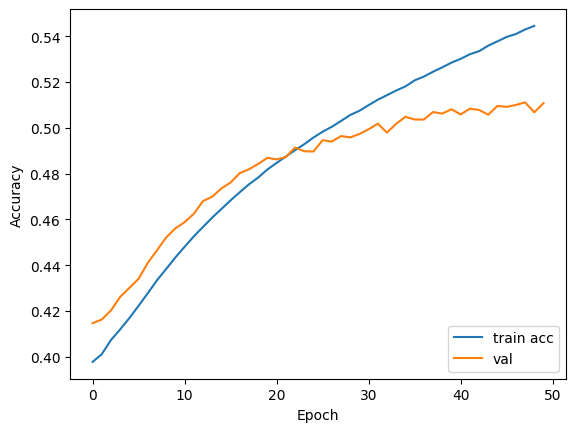

In [ ]:
# Accuracy
plt.plot(history.history['accuracy'][1:], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='test accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title('Encoder-Decoder model accuracy')

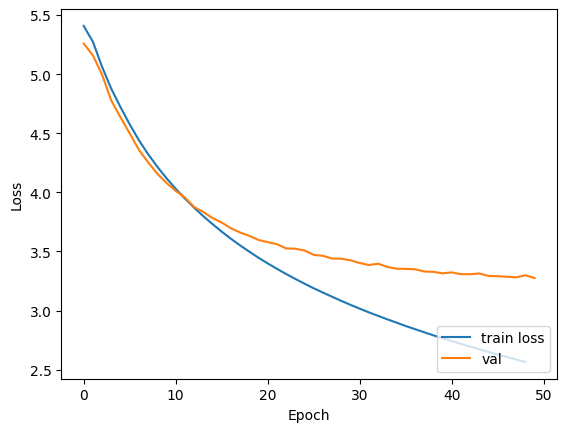

In [ ]:
# Loss
plt.plot(history.history['loss'][1:], label='train loss')
plt.plot(history.history['val_loss'], label='val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')
plt.title('Encoder-Decoder model loss')

Load saved model

In [ ]:
# load saved model
#encoder_decoder_model = tf.keras.models.load_model('/encoder_decoder_summarization_news_summary.h5')

# Check its architecture
#encoder_decoder_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 42)]         0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, 42, 300)      5789400     ['input_6[0][0]']                
                                                                                                  
 input_7 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 lstm_3 (LSTM)                  [(None, 42, 240),    519360      ['embedding_2[0][0]']            
                                 (None, 240),                                               

Inference models
Generating Predictions

In [ ]:
# build the dictionary to convert the index to word for target and source vocabulary:
reverse_target_word_index = y_tokenizer.index_word
reverse_source_word_index = x_tokenizer.index_word
target_word_index = y_tokenizer.word_index

In [ ]:
print(len(reverse_target_word_index))

39823


In [ ]:
# inference model
def build_seq2seq_model_with_just_lstm_inference(
    max_text_len, latent_dim, encoder_input, encoder_output,
    encoder_final_states, decoder_input, decoder_output,
    decoder_embedding_layer, decoder_dense, last_decoder_lstm
):
    # Encode the input sequence to get the feature vector
    encoder_model = Model(
        inputs=encoder_input, outputs=[encoder_output] + encoder_final_states
    )

    # Decoder setup
    # Below tensors will hold the states of the previous time step
    decoder_state_input_h = Input(shape=(latent_dim, ))
    decoder_state_input_c = Input(shape=(latent_dim, ))
    decoder_hidden_state_input = Input(shape=(max_text_len, latent_dim))

    # Get the embeddings of the decoder sequence
    decoder_embedding = decoder_embedding_layer(decoder_input)

    # To predict the next word in the sequence, set the initial
    # states to the states from the previous time step
    decoder_output, *decoder_states = last_decoder_lstm(
        decoder_embedding,
        initial_state=[decoder_state_input_h, decoder_state_input_c]
    )

    # A dense softmax layer to generate prob dist. over the target vocabulary
    decoder_output = decoder_dense(decoder_output)

    # Final decoder model
    decoder_model = Model(
        [decoder_input] + [decoder_hidden_state_input, decoder_state_input_h, decoder_state_input_c],
        [decoder_output] + decoder_states
    )

    return (encoder_model, decoder_model)

In [ ]:
encoder_model, decoder_model = build_seq2seq_model_with_just_lstm_inference(
    max_text_len, latent_dim, encoder_input, encoder_output,
    encoder_final_states, decoder_input, decoder_output,
    decoder_embedding_layer, decoder_dense, last_decoder_lstm
)

In [ ]:
encoder_model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 43)]              0         
                                                                 
 embedding_2 (Embedding)     (None, 43, 300)           31497900  
                                                                 
 lstm_3 (LSTM)               [(None, 43, 240),         519360    
                              (None, 240),                       
                              (None, 240)]                       
                                                                 
 lstm_4 (LSTM)               [(None, 43, 240),         461760    
                              (None, 240),                       
                              (None, 240)]                       
                                                                 
Total params: 32,479,020
Trainable params: 981,120
Non-trai

In [ ]:
decoder_model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 embedding_3 (Embedding)        (None, None, 300)    11947200    ['input_7[0][0]']                
                                                                                                  
 input_8 (InputLayer)           [(None, 240)]        0           []                               
                                                                                                  
 input_9 (InputLayer)           [(None, 240)]        0           []                               
                                                                                            

In [ ]:
# define decoder sequence
def decode_sequence_seq2seq_model_with_just_lstm(
    input_sequence, encoder_model, decoder_model
):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_sequence, verbose="False")

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1))

    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index[start_token]

    stop_condition = False
    decoded_sentence = ''

    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + [e_out, e_h, e_c],  verbose="False"
        )

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]

        if sampled_token != end_token:
          decoded_sentence += ' ' + sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == end_token) or (len(decoded_sentence.split()) >= (max_summary_len - 1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence


In [ ]:
def seq2summary(input_sequence):
    new_string = ''
    for i in input_sequence:
        if i != 0 and i != target_word_index[start_token] and i != target_word_index[end_token]:
              new_string = new_string + reverse_target_word_index[i] + ' '
    return new_string

def seq2text(input_sequence):
    new_string = ''
    for i in input_sequence:
        if i != 0:
            new_string = new_string + reverse_source_word_index[i] + ' '
    return new_string

In [ ]:
# Testing on training data
for i in range(0, 10):
    print(f"# {i+1} News: ", seq2text(x_train_padded[i]))
    print("Original summary: ", seq2summary(y_train_padded[i]))
    print(
        "Predicted summary: ",
        decode_sequence_seq2seq_model_with_just_lstm(
            x_train_padded[i].reshape(1, max_text_len), encoder_model, decoder_model))
    print("")

# 1 News:  salary allowances reimbursthements received punjab mlas displayed official website information immovable properties mlas mps state also put government website ruling congress party promised allowances received mlas would updated every month official website 
Original summary:  start salary allowances punjab mlas made public end 
Predicted summary:   start punjab mla gets allowances salary allowances post end

# 2 News:  human resource development ministry thursday launched atal ranking institutions intion achievthements ariia promote intion research higher education named former pm atal bihari vajpayee ariia rank educational institutions intion output based major indicators parameters used globally hrd minister prakash javadekar said 
Original summary:  start hrd ministry introduces atal ranking institutions end 
Predicted summary:   start govt forms government schools indias best curriculum end

# 3 News:  extratorrent worlds second largest torrent site pirate bay shut perm

For predicting unseen data pass decode_sequence function for which you want to decode.